In [37]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import csv
import pyiast



## Adsoorption using AiiDAlab
# Question 1:

AiiDAlab provides multiple ways to study adsorption. The three main type of calculation AiiDAlab uses are: XX, XX and XX

# Question 2:




In [38]:
data = {'Probe radius[A]': [1.525] ,'Density[g/cm^3]':[0.576983], 'Accesible Surface Area[A^2]':[0.0], 'Accessible preocupable volume [A^3]': [13428.1] , 'Porosity': [0.0]}

values= pd.DataFrame(data)
print(values)


   Probe radius[A]  Density[g/cm^3]  Accesible Surface Area[A^2]  \
0            1.525         0.576983                          0.0   

   Accessible preocupable volume [A^3]  Porosity  
0                              13428.1       0.0  


# Question 3

In [39]:
Henry_Co={'molecules': ["CO_2","CH_4"],'Henry coefficients at 300k[mol/kg/Pa]':[0.0, 1.12024e-06]}

henr= pd.DataFrame(Henry_Co)
print(henr)

  molecules  Henry coefficients at 300k[mol/kg/Pa]
0      CO_2                               0.000000
1      CH_4                               0.000001


One can notice that the Henry coefficient for CO_2 is XX than CH_4 at 300 K, this observation comes from the fact that XX. 

# Question 4

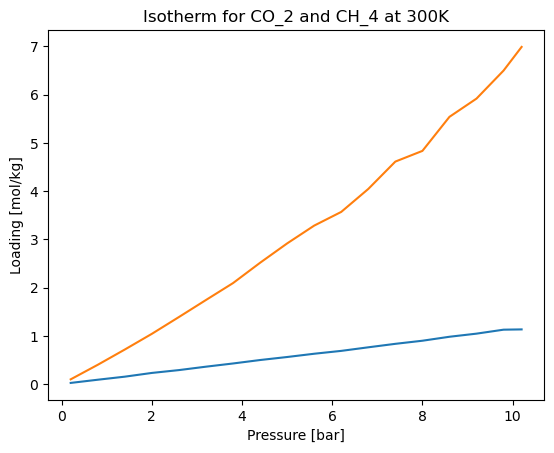

In [40]:
isotherme_ch=dict()
isotherme_co=dict()
with open('CH_4.csv', mode='r', encoding='utf-8') as CH_csv:
    lecteur_CH_csv = csv.reader(CH_csv)

    for index, ligne in enumerate(lecteur_CH_csv):
        if index == 35:
            isotherme_ch = eval(ligne[1])

with open('CO_2.csv', mode='r', encoding='utf-8') as CO_csv:
    lecteur_CO_csv = csv.reader(CO_csv)

    for index, ligne in enumerate(lecteur_CO_csv):
        if index == 35:
            isotherme_co = eval(ligne[1])


pressure_x = isotherme_ch['pressure']
adsorption_ch_4 =isotherme_ch['loading_absolute_average']
adsorption_co_2 = isotherme_co['loading_absolute_average']

plt.plot(pressure_x,adsorption_ch_4, label='CH_4')
plt.plot(pressure_x,adsorption_co_2, label='CO_2')
plt.title("Isotherm for CO_2 and CH_4 at 300K")
plt.xlabel("Pressure [bar]")
plt.ylabel("Loading [mol/kg]")

plt.show()

# Question 5


                      Component 0: p^0 = 10.752822 > 10.200000, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.


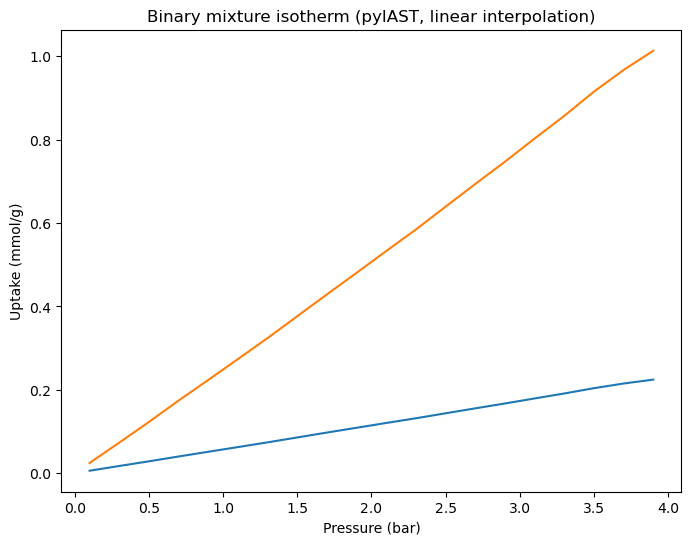

In [41]:
ch_panda=pd.DataFrame({"pressure": pressure_x, "loadings":adsorption_ch_4})
co_panda=pd.DataFrame({"pressure": pressure_x, "loadings":adsorption_co_2})

isotherm1 = pyiast.InterpolatorIsotherm(ch_panda, loading_key="loadings", pressure_key="pressure",fill_value=ch_panda['loadings'].iloc[-1])
isotherm2 = pyiast.InterpolatorIsotherm(co_panda, loading_key="loadings", pressure_key="pressure",fill_value=co_panda['loadings'].iloc[-1])


# === Define binary gas mixture ===
# Example: equimolar feed (50% comp1, 50% comp2)
#one could edit the code to allow the user to choosethe composition of the mixture 
y = [0.5, 0.5]

# Pressure range: 0.1 to 4.0, step 0.2
P_range = np.arange(0.1, 4.0, 0.2)

# Store mixture adsorption results
mixture_loadings = []

for P in P_range:
    res = pyiast.iast(partial_pressures=[P * y[0], P * y[1]],isotherms= [isotherm1, isotherm2])
    mixture_loadings.append(res)

mixture_loadings = np.array(mixture_loadings)

# === Plot results ===
plt.figure(figsize=(8,6))
plt.plot(P_range, mixture_loadings[:,0], label="CH_4 uptake")
plt.plot(P_range, mixture_loadings[:,1], label="C0_2 uptake")
plt.xlabel("Pressure (bar)")
plt.ylabel("Uptake (mmol/g)")
plt.title("Binary mixture isotherm (pyIAST, linear interpolation)")
plt.show()